#### **Example notebook for BCI Fitts task with click decoding**

We use our usual closed-loop simulator but with a couple innovations:
- an orthogonal neural dimension (to velocity) encoding the click signal
- a click decoder that reads out click-related activity (logistic regression)
- a drift-diffusion click signal model where:

    $C_t = C_{t-1} + \alpha * e_{t}  + N(decay, \sigma^{2})$
    

The evidence term is a nonlinear weighting of the distance to target, given by a logistic decay function:

$e_{t} = 1 / (1 + e^{20(distance - 0.07)} )$

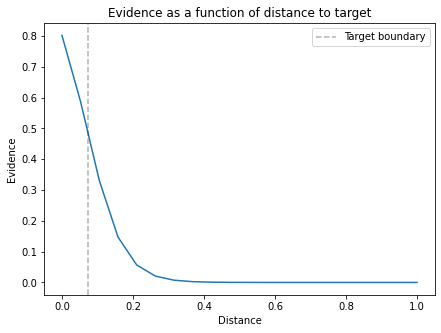

In [19]:
import numpy as np 
import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
import matplotlib.pyplot as plt

# let's plot the evidence function
x = np.linspace(0, 1, 20)
y = 1 / (1 + np.exp(1 * (x - 0.07) * 20)) 

figSize(5, 7)
plt.plot(x, y)
plt.axvline(0.0725, linestyle = '--', color = 'k', alpha  = 0.3, label = 'Target boundary')
plt.title('Evidence as a function of distance to target')
plt.xlabel('Distance')
plt.ylabel('Evidence')
plt.legend()

In [20]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
from simulation_utils import * 
from stabilizer_utils import *
from simulation import *


# for a reproducible result
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

cursorTuning   = generateUnits(n_units = nUnits, SNR = SNR)
clickTuning    = orthogonalizeAgainst(np.random.normal(size = (192,)), cursorTuning[:, 1])
clickTuning    = orthogonalizeAgainst(clickTuning / np.linalg.norm(clickTuning), cursorTuning[:, 2])[:, np.newaxis] 


calNeural, calVelocity = simulateUnitActivity(cursorTuning, noise = 0.3, nSteps = nTrainingSteps)
lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(cursorTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(cursorTuning[:, 2])

In [22]:
alpha       = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
delT        = 0.01 # define the time step (10 ms)
nDelaySteps = 20   # define the simulated user's visual feedback delay (200 ms)


# Do a quick sweep of cursor gains to find the optimal one for this task:

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
nSimSteps    = 50000
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    posTraj, velTraj, rawDecTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts(cursorTuning, D, alpha, possibleGain[g], nDelaySteps, delT, nSimSteps)
    meanTTT[g] = np.mean(ttt)

minIdx = np.argmin(meanTTT)
beta   = possibleGain[minIdx]

print('Using gain value beta = ', beta)

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  1.1666666666666665


## Click decoder construction

As in *Kao, Nuyujukian, et al. (2017)*, we first simulate a series of hold tasks during which the user must dwell over a target for 500 ms. We then classify hold states as those in the $[+250, +500] ms$ period following initial target acquisition.

In [23]:
dist_threshold  = 0.075  # classify timepoints that are within certain distance from target as a click
dec_window      = 5     # number of time points for decoder to use
PCA_nComponents = 4

# simulate some open loop click data - target dwell logic is used to move to next trial
D_click = None

posTraj, velTraj, rawDecTraj, _, _, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts_click(cursorTuning, clickTuning, D, D_click, alpha, beta, nDelaySteps, delT, nSimSteps, ClickLogic = False)

targets = np.zeros((len(neuralTraj),))
for t in trialStart:
    targets[(t - 25):t] = 1

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

decoder = Pipeline([('PCA', PCA(n_components = PCA_nComponents)), ('Logistic', LogisticRegression(class_weight = 'balanced', max_iter = 3000))])
#decoder = Pipeline([('PCA', PCA(n_components = 192)), ('Linear', LinearRegression())])

decoder.fit(X = neuralTraj, y = targets)

Pipeline(steps=[('PCA', PCA(n_components=4)),
                ('Logistic',
                 LogisticRegression(class_weight='balanced', max_iter=3000))])

(0.0, 0.15)

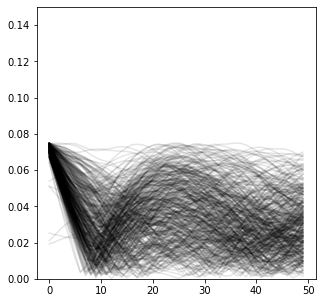

In [25]:
for i, t in enumerate(trialStart):
    if ttt[i] < 10:
        trl_dists = np.linalg.norm(posTraj - targTraj, axis = 1)
        plt.plot(trl_dists[(t-50):t], color = 'k', alpha = 0.1)
plt.ylim([0, 0.15])

In [52]:

posTraj, velTraj, rawDecTraj, _, _, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts_click(cursorTuning, clickTuning, D, D_click, alpha, beta, nDelaySteps, delT, nSimSteps, ClickLogic = False)
dists = np.linalg.norm(posTraj - targTraj, axis = 1)

Text(0.5, 1.0, 'Click decoder performance')

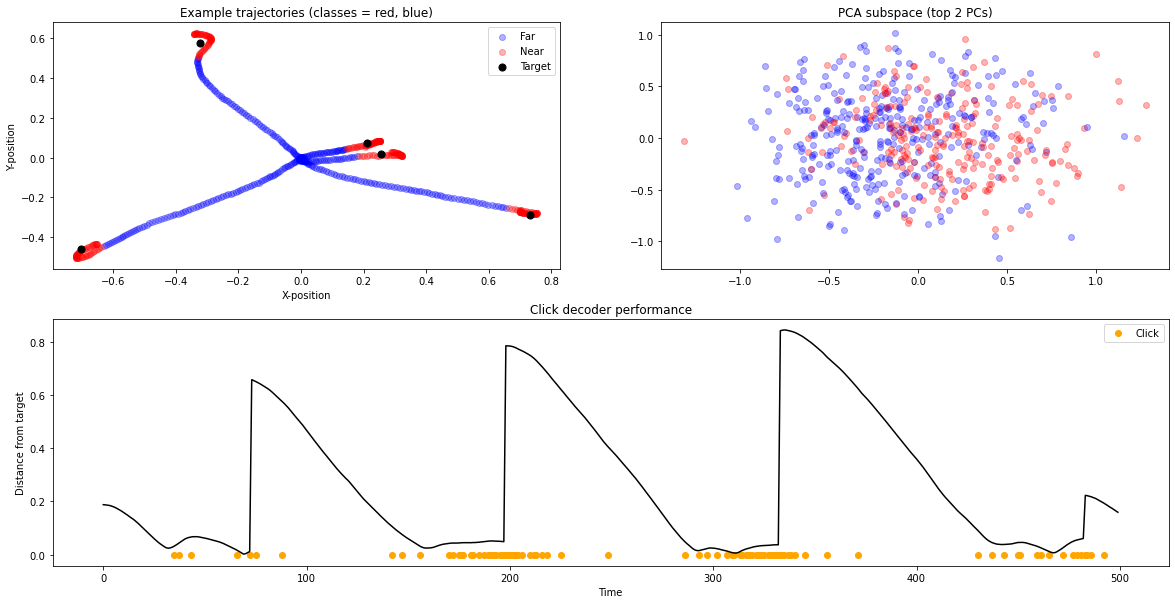

In [53]:
figSize(10, 20)


plt.subplot(2, 2, 1)
plt.title('Example trajectories (classes = red, blue)')
plt.xlabel('X-position')
plt.ylabel('Y-position')

for i in range(5):
    start = trialStart[i]
    stop  = trialStart[i+1] 
    
    cursor_trl = posTraj[start:stop, :] - posTraj[start, :]
    targ_trl   = targTraj[start, :]  - posTraj[start, :]
    dist_trl   = np.linalg.norm(cursor_trl - targ_trl, axis = 1) < dist_threshold
    
    plt.scatter(cursor_trl[dist_trl == False, 0], cursor_trl[dist_trl == False, 1], alpha = 0.3, color = 'b', label = 'Far')
    plt.scatter(cursor_trl[dist_trl == True, 0], cursor_trl[dist_trl == True, 1], alpha = 0.3, color = 'r', label = 'Near')

    plt.scatter(targ_trl[0], targ_trl[1], color = 'k', s = 50, label = 'Target')
    if i == 0:
        plt.legend()
        
plt.subplot(2, 2, 2)
plt.title('PCA subspace (top 2 PCs)')

for i in range(5):
    start = trialStart[i]
    stop  = trialStart[i+1] 
    
    cursor_trl = posTraj[start:stop, :] - posTraj[start, :]
    targ_trl   = targTraj[start, :]  - posTraj[start, :]
    dist_trl   = np.linalg.norm(cursor_trl - targ_trl, axis = 1) < 0.075
    
    PCs = decoder['PCA'].transform(neuralTraj[start:stop, :])
    plt.scatter(PCs[dist_trl == False, 0], PCs[dist_trl == False, 1], alpha = 0.3, color = 'b', label = 'Far')
    plt.scatter(PCs[dist_trl == True, 0], PCs[dist_trl == True, 1], alpha = 0.3, color = 'r', label = 'Near')

        
plt.subplot(2, 1, 2)
timelen   = 500
PredClick = np.where(decoder.predict_proba(neuralTraj[:timelen, :])[:, 1] > 0.60)[0]


plt.plot(dists[:timelen], color = 'k')
plt.scatter(PredClick, np.zeros((len(PredClick))), color = 'orange', label = 'Click')
plt.ylabel('Distance from target')
plt.xlabel('Time')
plt.legend()
plt.title('Click decoder predictions (no smoothing)')
#click_dec.pr


In [54]:
# now generate some simulated data with optimal gain:

D_click = [decoder, 0.7]

posTraj, posErr_est, velTraj, rawDecTraj, clickMagTraj, clickTraj, conTraj, targTraj, neuralTraj, trialStart, ttt = simulateBCIFitts_click(cursorTuning, clickTuning, D, D_click, alpha, beta, nDelaySteps, delT, nSimSteps, return_PosErr = True, ClickLogic = True)

dist           = np.linalg.norm(posTraj - targTraj, axis = 1)
est_dist       = np.linalg.norm(posErr_est, axis = 1)
decodedMag     = decoder.predict_proba(neuralTraj)[:, 1]
#decodedMag     = (neuralTraj - cursorTuning[:, 0]).dot(clickTuning)  # invert our encoding model 

Text(0.5, 1.0, 'Click signal magnitude across time')

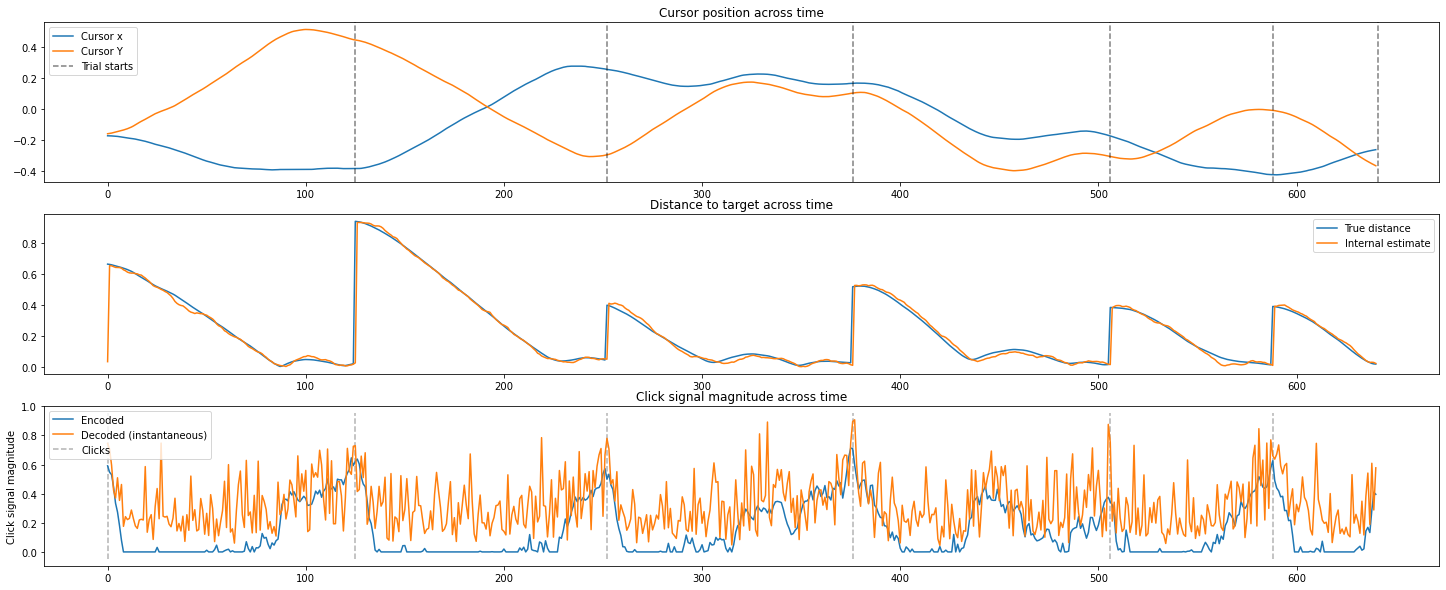

In [56]:
figSize(10, 25)

i      = 5  # starting trial index
n_trls = 6  # number of consecutive trials to plot 

start = trialStart[i]
stop  = trialStart[i + n_trls]

plt.subplot(3, 1, 1)
plt.title('')
plt.plot(posTraj[start:stop, :])
for j in range(1, n_trls + 1):
    plt.axvline(trialStart[i + j] - start,  color = 'k', linestyle = '--', alpha = 0.5)
plt.legend(['Cursor x', 'Cursor Y', 'Trial starts'])
plt.title('Cursor position across time', fontsize = 12)
#plt.axvline()

plt.subplot(3, 1, 2)
plt.plot(dist[start:stop], label = 'True distance')
plt.plot(est_dist[start:stop], label = 'Internal estimate')
plt.legend()
plt.title('Distance to target across time', fontsize = 12)

plt.subplot(3, 1, 3)
plt.plot(clickMagTraj[start:stop], label = 'Encoded')
plt.plot(decodedMag[start:stop], label = 'Decoded (instantaneous)')

click_times = np.where(clickTraj[start:stop] == 1)[0]
ylims       = plt.ylim()
plt.vlines(click_times, ymin = ylims[0], ymax = ylims[1], color = 'k', alpha = 0.3, linestyle = '--', label = 'Clicks')

plt.legend()
plt.ylabel('Click signal magnitude')
plt.title('Click signal magnitude across time')

In [57]:
t = 20

In [62]:
isinstance(t, int)

True